# **Stereo Disparity with Dynamic Programming**

In [0]:
import cv2
import numpy as np
import sys
import networkx as nx
import matplotlib.pyplot as plt
np.set_printoptions(threshold=sys.maxsize)
from tqdm import tqdm

***First Step: Read Images***


*  We have several samples of the same view translated in parallel view (Left image , Right image). 
*   We also load Ground truth for disparities of these images


Note: we have two choices of resizing the images or leaving them with full scale..

- using resized images will result ( faster computations but less clear disparity , direction graph will appear clearer)


In [0]:
left_img = cv2.imread('im6.ppm',0)
right_img = cv2.imread('im2.ppm',0)
left_disp_GD = cv2.imread('disp6.pgm',0)
right_disp_GD = cv2.imread('disp2.pgm',0)

imgH = left_img.shape[1]
imgW = left_img.shape[0]
resizeFactor = 100

#left_img = cv2.resize(left_img,None,fx=100/imgW,fy=100/imgH, interpolation = cv2.INTER_AREA)
#right_img = cv2.resize(right_img,None,fx=100/imgW,fy=100/imgH, interpolation = cv2.INTER_AREA)
#left_disp_GD = cv2.resize(left_disp_GD,None,fx=100/imgW,fy=100/imgH, interpolation = cv2.INTER_AREA)
#right_disp_GD = cv2.resize(right_disp_GD,None,fx=100/imgW,fy=100/imgH, interpolation = cv2.INTER_AREA)

left_img = np.asarray(left_img, dtype = np.float)
right_img = np.asarray(right_img, dtype = np.float)
left_disp_GD = np.asarray(left_disp_GD, dtype = np.float)
right_disp_GD = np.asarray(right_disp_GD, dtype = np.float)

In [0]:
#left_img?
right_disp_GD.shape

(375, 450)

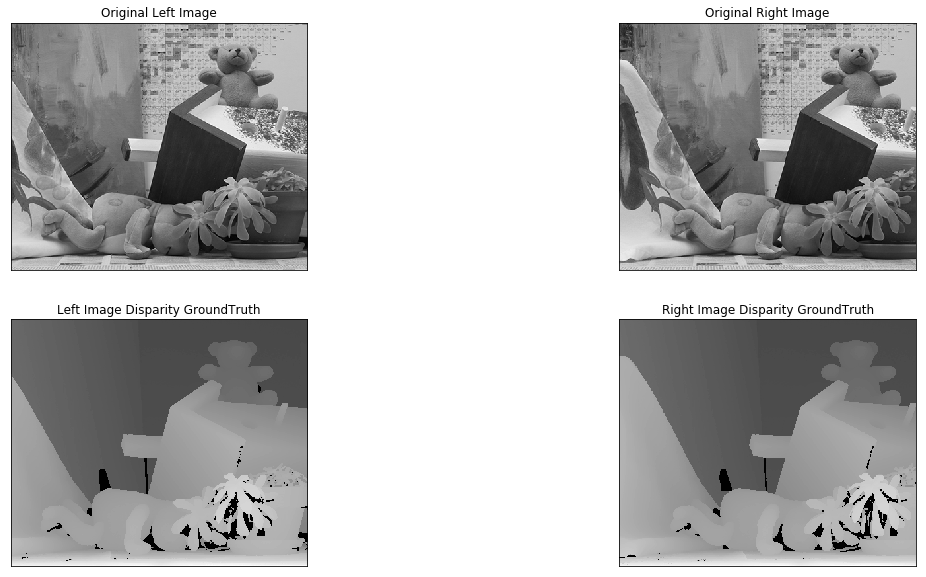

In [0]:
plt.figure(figsize=(20,10))
plt.subplot(221),plt.imshow(left_img, cmap = 'gray')
plt.title('Original Left Image'), plt.xticks([]), plt.yticks([])

plt.subplot(222),plt.imshow(right_img, cmap = 'gray')
plt.title('Original Right Image'), plt.xticks([]), plt.yticks([])

plt.subplot(223),plt.imshow(left_disp_GD, cmap = 'gray')
plt.title('Left Image Disparity GroundTruth'), plt.xticks([]), plt.yticks([])

plt.subplot(224),plt.imshow(right_disp_GD, cmap = 'gray')
plt.title('Right Image Disparity GroundTruth'), plt.xticks([]), plt.yticks([])
plt.show()

In [0]:
left_img.shape

(375, 450)

This function used to **calculate dij which is the cost associated with
matching pixel Il(i) with pixel Ir(j)**. Here we consider a squared error measure between pixels
given by:

![alt text](https://scontent-mxp1-1.xx.fbcdn.net/v/t1.15752-9/60303893_307421603484247_8829767567263399936_n.jpg?_nc_cat=111&_nc_ht=scontent-mxp1-1.xx&oh=863a82008f917b6f8879c0cebea3271a&oe=5D6784C6)


where σ is some measure of pixel noise

In [0]:
def matchingPixelsCost(p1,p2):
    noiseMeasure = 2
    d = ((p1-p2)**2)/noiseMeasure**2
    return d

This Function used To plot images, if the image is not clear enough we pass parameter called vmax to the function to make 
the photo more clear since some values are very large resulting mapping most of the other pixels to black

In [0]:
def plotArray(arr,Vmax = False):
    plt.figure(figsize = (15,10))
    if(Vmax == True):
        vmax = arr.max()/40
        plt.imshow(arr, cmap = 'gray', aspect='auto' )
    else:
        plt.imshow(arr, cmap = 'gray', aspect='auto' )
    plt.colorbar()

Step 2: The algorithm



*   we can compute the optimal (minimal cost) alignment of two scanlines recursively as
follows:
![alt text](https://scontent-mia3-1.xx.fbcdn.net/v/t1.15752-9/60396487_1171008013082219_3230471742019338240_n.jpg?_nc_cat=108&_nc_ht=scontent-mia3-1.xx&oh=141bfa692efc833ff0a3342a6d1dde96&oe=5D63AD3D)
  

    *   The cost of skipping a pixel (in either scanline) is given by a constant c0.


*  ![alt text](https://scontent-mia3-1.xx.fbcdn.net/v/t1.15752-9/60226934_2318562801765257_6802626781183475712_n.png?_nc_cat=110&_nc_ht=scontent-mia3-1.xx&oh=3b71c42319dc187a142b66ff759dc750&oe=5D9E0A81)

* **Note:** C or D are considered the cost matrix



Matching Scan Lines: 100%|████████████████████████████████████████████████████████████████████████ [ time left: 00:00 ]

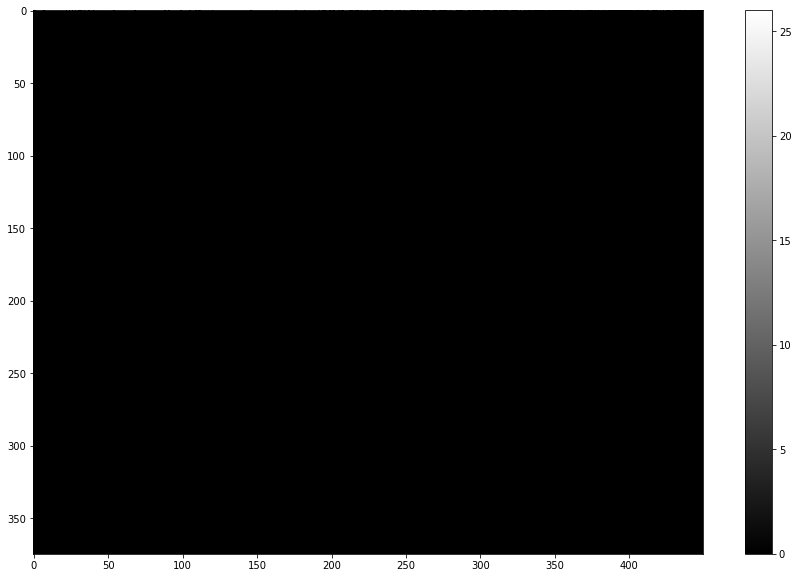

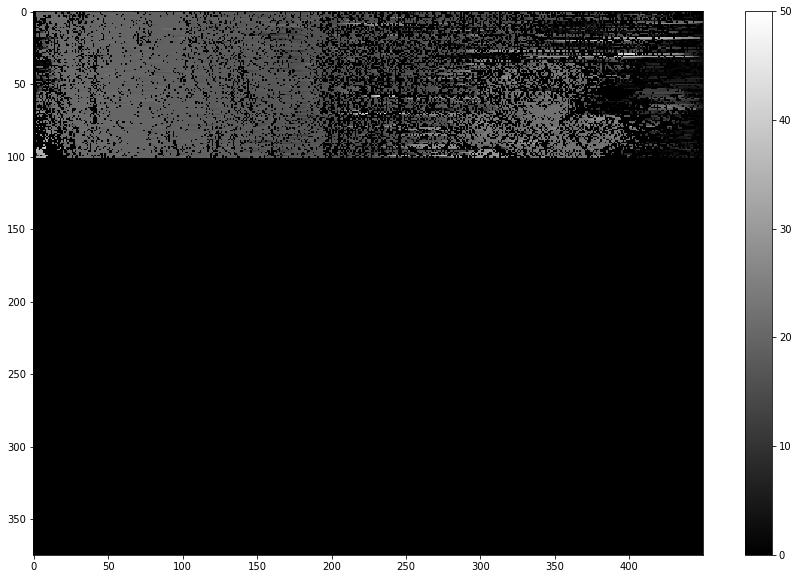

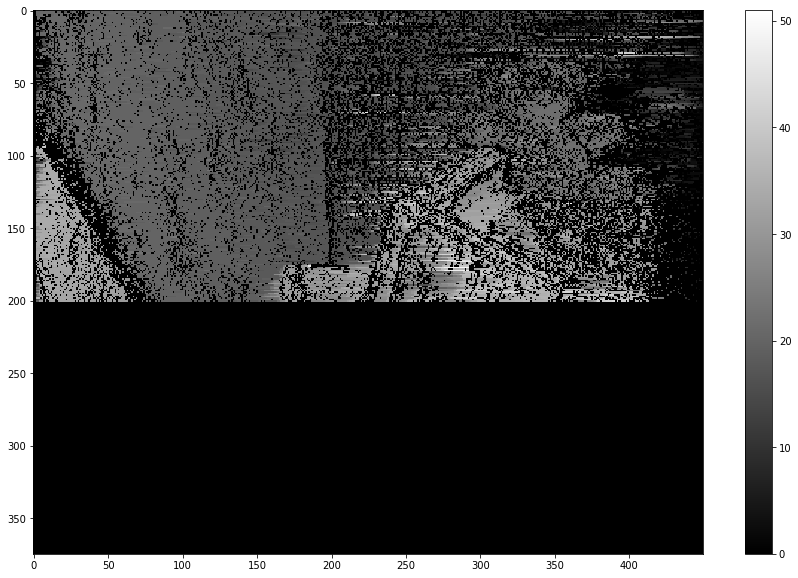

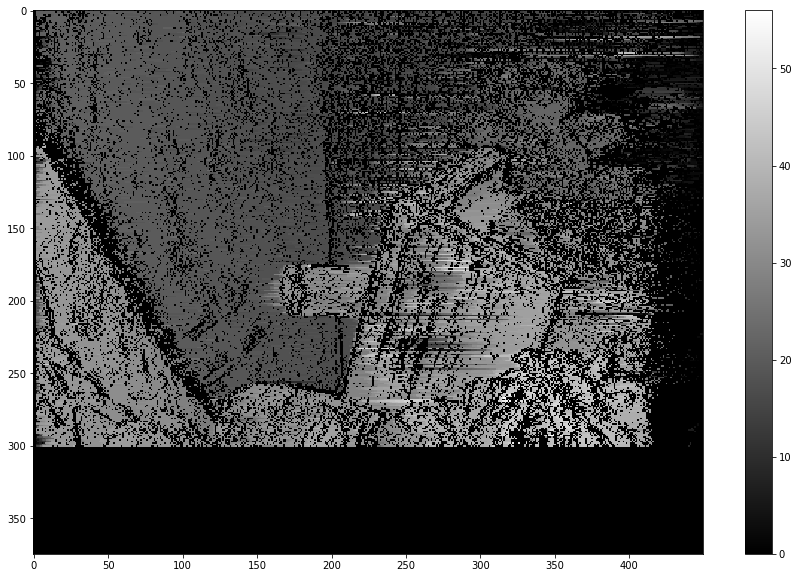

In [0]:
disparity_Map_Left = np.zeros(shape = left_img.shape, dtype='float')
disparity_Map_Right = np.zeros(shape = right_img.shape, dtype='float')

loadingBar = tqdm(total=left_img.shape[0], desc="Matching Scan Lines", bar_format="{l_bar}{bar} [ time left: {remaining} ]")


for row in range(left_img.shape[0]):
    
#     print row

    C0 = 1 #(occlusionCost)You can adjust this, depending on how much threshold you want to give for noise)
    
    #For Dynamic Programming you have build a cost matrix. Its dimension will be numcols x numcols
    
    numcols = left_img.shape[1]
    
    D = np.zeros(shape=(numcols,numcols), dtype='float') #costMatrix
    directionMatrix = np.zeros(shape=(numcols,numcols))  #(This is important in Dynamic Programming. You need to know which direction you need traverse)
    
    for i in range(numcols):
        D[i,0] = float('inf')
        D[0,i] = float('inf')
        
    
    scanLine1 = left_img[row,:]
    scanLine2 = right_img[row,:]
    #print(scanLine1[0])
    
    D[0,0] = matchingPixelsCost(scanLine1[0],scanLine2[0])
    
    for i in range(1, numcols):
        for j in range(1, numcols):
             
            min1 = D[i-1,j-1] + matchingPixelsCost(scanLine1[i],scanLine2[j])
            min2 = D[i-1,j] + C0
            min3 = D[i,j-1] + C0 
            D[i,j] = min(min1,min2,min3)
            
            if min1 == D[i,j]:
                directionMatrix[i,j] = 1
            elif min2 == D[i,j]:
                directionMatrix[i,j] = 2
            else:
                directionMatrix[i,j] = 3
    
    left_Xcor = numcols - 1
    right_Xcor = numcols - 1
        
    while(left_Xcor != 0 and right_Xcor !=0):
            
        # if feature in left and right image matches
        if(directionMatrix[left_Xcor, right_Xcor] == 1):
            disparity_Map_Left[row, left_Xcor] = abs(left_Xcor-right_Xcor)
            disparity_Map_Right[row, right_Xcor] = abs(left_Xcor-right_Xcor)                
            left_Xcor = left_Xcor - 1
            right_Xcor = right_Xcor - 1
                
        # if feature in left image is occuluded
        elif(directionMatrix[left_Xcor, right_Xcor] == 2):
            disparity_Map_Left[row, left_Xcor] = 0
            left_Xcor = left_Xcor - 1
        
        # if feature in right image is occuluded
        elif(directionMatrix[left_Xcor, right_Xcor] == 3):
            disparity_Map_Right[row, right_Xcor] = 0
            right_Xcor = right_Xcor - 1
    if(row%100 == 0):        
        plotArray(disparity_Map_Left)
    # update the bar
    loadingBar.update(1)

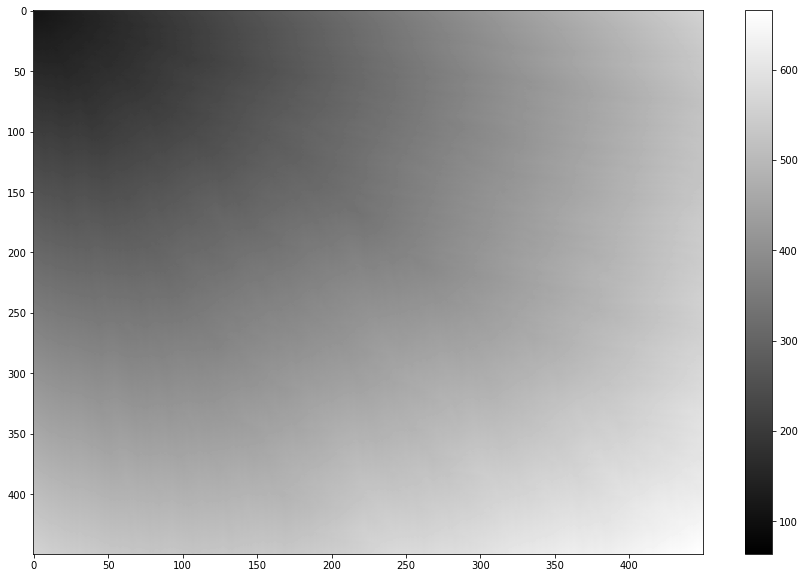

In [0]:
plotArray(D)

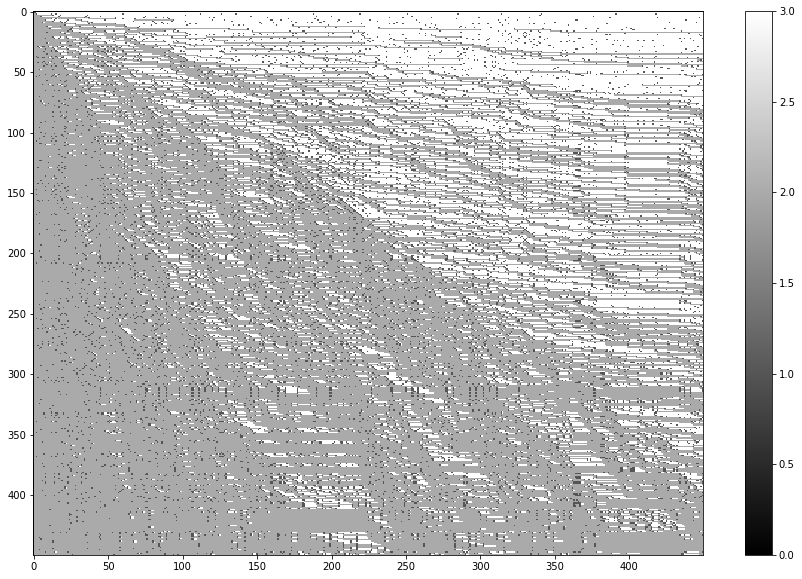

In [0]:
plotArray(directionMatrix)

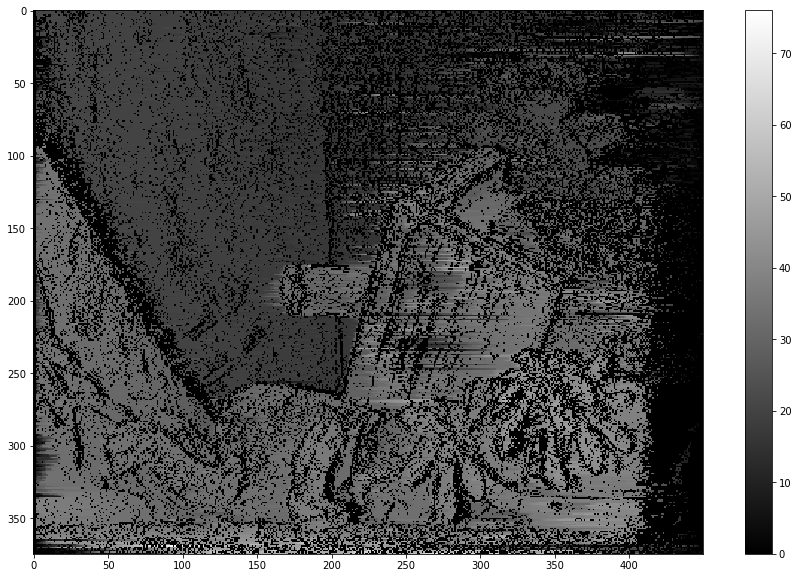

In [0]:
plotArray(disparity_Map_Left,True)

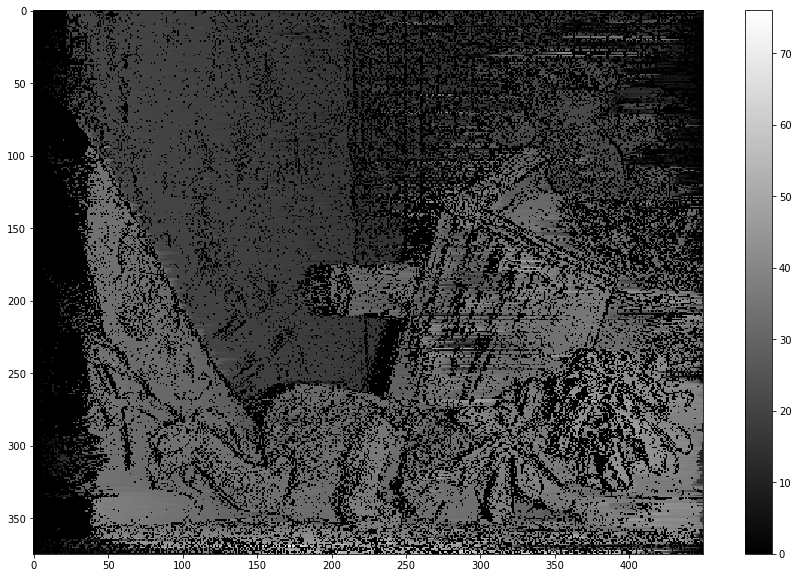

In [0]:
plotArray(disparity_Map_Right,True)

# **Optional Part1**

![alt text](https://scontent-hbe1-1.xx.fbcdn.net/v/t1.15752-9/60197731_417127422174057_5790580113691115520_n.png?_nc_cat=111&_nc_ht=scontent-hbe1-1.xx&oh=788a199e4774a3b88381d7f1597bef0c&oe=5D610C04)

In [0]:
def occulationFill(arr):
    for row in range(left_img.shape[0]):
        occFiller = 0
        scanLine = arr[row]
        for i,pixel in enumerate(scanLine):
            if(scanLine[i] != 0):
                occFiller = scanLine[i]
            else:
                arr[row][i] = occFiller
    return arr

In [0]:
disparity_Map_Left = occulationFill(disparity_Map_Left)

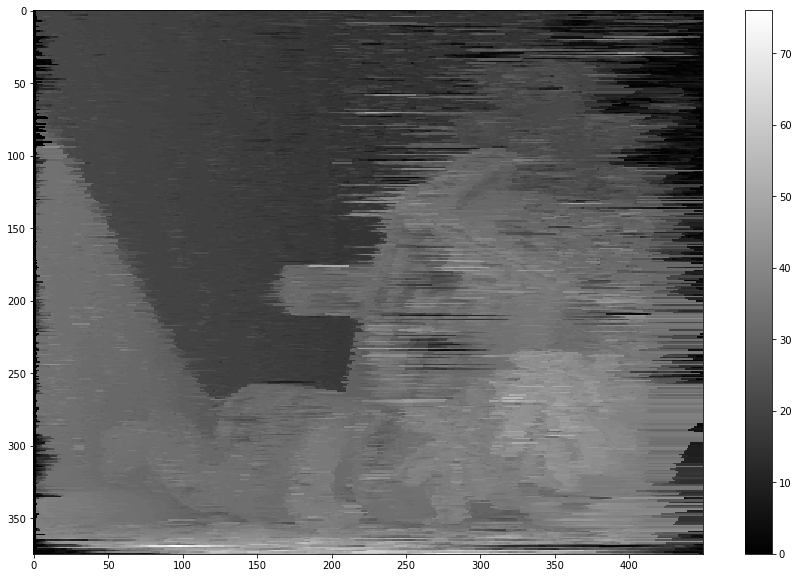

In [0]:
plotArray(disparity_Map_Left,True)

In [0]:
disparity_Map_Right = occulationFill(disparity_Map_Right)

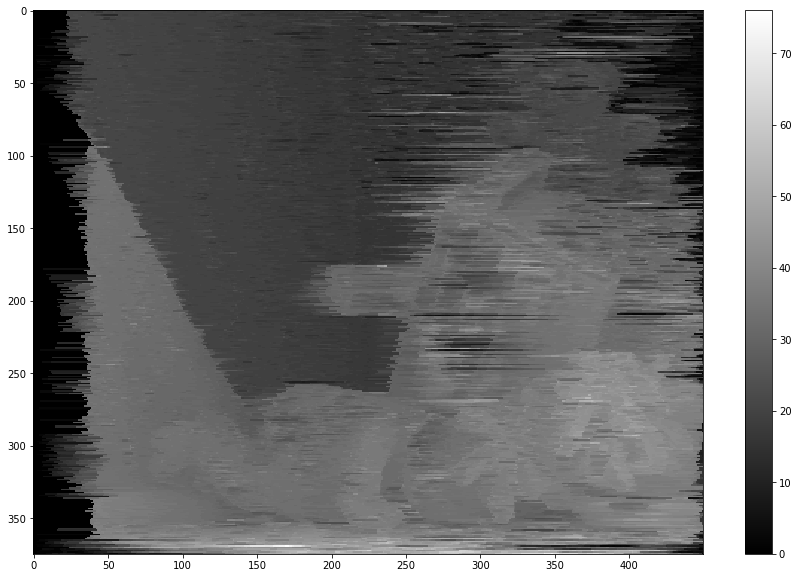

In [0]:
plotArray(disparity_Map_Right,True)

In [0]:
directionMatrix[-10:,-10:]

array([[ 2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.],
       [ 2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.],
       [ 2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.],
       [ 2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.],
       [ 2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.],
       [ 2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.],
       [ 2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.],
       [ 3.,  3.,  3.,  3.,  3.,  3.,  3.,  2.,  2.,  1.],
       [ 2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.],
       [ 3.,  3.,  3.,  3.,  3.,  3.,  3.,  2.,  2.,  2.]])

In [0]:
D[:5,:5]

array([[  64.,   inf,   inf,   inf,   inf],
       [  inf,  113.,  114.,  115.,  116.],
       [  inf,  114.,  113.,  114.,  115.],
       [  inf,  115.,  114.,  115.,  116.],
       [  inf,  116.,  115.,  116.,  117.]])

In [0]:
directionMatrix[:5,:5]

array([[ 0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  3.,  3.,  3.],
       [ 0.,  2.,  1.,  3.,  3.],
       [ 0.,  2.,  2.,  2.,  2.],
       [ 0.,  2.,  2.,  2.,  2.]])

# **Optional Part2: Shortest Matching Path**

In [0]:
import matplotlib.gridspec as gridspec

N = left_img.shape[1]
#N =5
if(N<=10):
    f = plt.figure(figsize = ((N-1)*2,(N-1)*2))
else:
    f = plt.figure(figsize = ((N-1)/2,(N-1)/2))

gs = gridspec.GridSpec(2, 2,
                       width_ratios=[1, 2], height_ratios=[4, 1])
#gs.update(wspace=0.1, hspace=0.1)

ax1 = plt.subplot(gs[1])


G=nx.grid_2d_graph(N,N)
pos = dict( (n, n) for n in G.nodes() )
labels = dict( ((i, j), i + (N-1-j) * 10 ) for i, j in G.nodes() )
#print(labels)
edges = list()
#nx.draw_networkx(G, pos=pos, labels=labels)
#plt.figure(figsize = (30,30))
#ax = plt.subplot(2, 1, 1)

j = D.shape[0] - 1
k = D. shape[1] - 1
graph_i = N - 1
#graph_j = 0
graph_j = N - 1
while graph_i > 0 and graph_j > 0:
    #print(str(j)+" "+str(k))
    #print(directionMatrix[j][k])
    #print(str(graph_i)+" "+str(graph_j))
    if(directionMatrix[j][k] == 1):
        edges.append([(graph_i,graph_j),(graph_i-1, graph_j-1)])
        graph_i-=1
        graph_j-=1
        j-=1
        k-=1
    elif(directionMatrix[j][k] == 2):
        edges.append([(graph_i,graph_j),(graph_i, graph_j-1)])
        graph_j-=1
        j-=1
    elif(directionMatrix[j][k] == 3):
        edges.append([(graph_i,graph_j),(graph_i-1, graph_j)])
        graph_i-=1
        k-=1
    else:
        print(str(j)+" "+str(k))
        break
#print(edges)
nx.draw(
            G,
            edgelist=edges,
            width=3,
            pos={node: node for node in G.nodes()},
            labels = labels,
            with_labels = False,
            node_size=20,
            edge_color = 'blue'
        )

plt.axis('on')

plt.xticks(np.arange(0, N, step=1))
plt.yticks(np.arange(0, N, step=1))

ax1.xaxis.tick_top()
ax1.invert_yaxis()
plt.grid()

data = np.expand_dims(left_img[-1][-N+1:], axis=0)
# Limits for the extent
x_start = 0
x_end = N-1
y_start = 0
y_end = 1

extent = [x_start, x_end, y_start, y_end]
ax2 = plt.subplot(gs[3])
ax2.imshow(data, extent=extent, origin='lower', interpolation='None', cmap='viridis')
plt.xticks(np.arange(0, N, step=1))

ax2.get_yaxis().set_visible(False)
#plt.grid()

data = np.expand_dims(right_img[-1][-N+1:], axis=1)
# Limits for the extent
x_start = 0
x_end = 1
y_start = 0
y_end = N-1

extent = [x_start, x_end, y_start, y_end]
ax3 = plt.subplot(gs[0])
im3 = ax3.imshow(data, extent=extent, origin='lower', interpolation='None', cmap='viridis')
ax3.invert_yaxis()
ax3.get_xaxis().set_visible(False)
plt.yticks(np.arange(0, N, step=1))

plt.colorbar(im3)
plt.show()

# **Comparison:**



1.   **Co = 1**:  since Co is occulation cost, so having low value of co we will notice that the algorithm will choose occulating pixels more often than matching them... matching pixels will be more reliable since they are more guranteed to be closely matching.

- Left diparity & Right disparity
![alt text](https://scontent-mia3-2.xx.fbcdn.net/v/t1.15752-9/60230682_2156759527754805_8433429041750474752_n.png?_nc_cat=101&_nc_ht=scontent-mia3-2.xx&oh=18d819dfe0a48632e689227bfe66a148&oe=5D73AB30)
![alt text](https://scontent-mia3-2.xx.fbcdn.net/v/t1.15752-9/60360155_377057586239541_6993902711624171520_n.png?_nc_cat=104&_nc_ht=scontent-mia3-2.xx&oh=11c8dfb9b6e307082eba1520f0193c6d&oe=5D5CD9A0)

- Shortest Matching Path (best cost matching for last row) 
![alt text](https://scontent-mia3-2.xx.fbcdn.net/v/t1.15752-9/60364148_800670873650155_2048328216233377792_n.png?_nc_cat=111&_nc_ht=scontent-mia3-2.xx&oh=60708ba469a99efc794c8b8e4ed4671c&oe=5D9FBE9C)

2.   **Co = 10**:  it's the other extreme which we will notice clearly less number of occulated pixels, since occulation cost is greatly increased

- Left diparity & Right disparity
![alt text](https://scontent-mia3-2.xx.fbcdn.net/v/t1.15752-9/60187457_650946932012121_2343875627519574016_n.png?_nc_cat=106&_nc_ht=scontent-mia3-2.xx&oh=b99f83d2711fb5af9b64194ab3568364&oe=5D69D7B8)
![alt text](https://scontent-mia3-2.xx.fbcdn.net/v/t1.15752-9/60286009_304642587117163_6603162203535179776_n.png?_nc_cat=101&_nc_ht=scontent-mia3-2.xx&oh=02a34009919cfd2684dbcac7ce7a1937&oe=5D9E62C2)

- Shortest Matching Path (best cost matching for last row) 
![alt text](https://scontent-mia3-2.xx.fbcdn.net/v/t1.15752-9/60181947_289798638639458_5667352975073345536_n.png?_nc_cat=103&_nc_ht=scontent-mia3-2.xx&oh=ced7a747ec3384698103515f82148827&oe=5D71168C)

3.  **Co = 5**:  it's more balanced

- Left diparity & Right disparity
![alt text](https://scontent-mia3-2.xx.fbcdn.net/v/t1.15752-9/60295472_2606843009543817_3316936584808366080_n.png?_nc_cat=102&_nc_ht=scontent-mia3-2.xx&oh=225fa7806915c5ff303980d71ca448ef&oe=5D54262B)
![alt text](https://scontent-mia3-2.xx.fbcdn.net/v/t1.15752-9/60723376_2053297768129254_4179355276131958784_n.png?_nc_cat=111&_nc_ht=scontent-mia3-2.xx&oh=e64ec30a93d42dee8f172f152bbcb19e&oe=5D51DAC7)

- Shortest Matching Path (best cost matching for last row) 
![alt text](https://scontent-mia3-2.xx.fbcdn.net/v/t1.15752-9/60276597_327488307915048_6811765071430025216_n.png?_nc_cat=105&_nc_ht=scontent-mia3-2.xx&oh=953c7153e6e65d779120a99f273ad1d9&oe=5D716576)